In [143]:
import numpy as np
from pandas import read_csv
import pandas_datareader.data as web
import matplotlib.pyplot as plt


In [144]:
lstm_data = read_csv('lstmona.csv')
lstm_data = lstm_data.drop(['Date'], axis=1)
print(lstm_data)

        High       Low      Open     Close   Volume  Adj Close  Polarity Score
0   1.241455  1.182781  1.236694  1.184539  1251855   1.184539        0.095867
1   1.054188  1.000561  1.016678  1.008785   467346   1.008785        0.146020
2   1.022445  0.989817  1.014940  0.996675   304333   0.996675        0.138143
3   0.978820  0.965322  0.970673  0.972663   205397   0.972663        0.146417
4   0.815332  0.799816  0.809788  0.803426   128781   0.803426        0.134860
..       ...       ...       ...       ...      ...        ...             ...
63  1.020251  0.994093  1.002975  0.999426   565050   0.999426        0.114973
64  0.851174  0.818889  0.843720  0.824758   153179   0.824758        0.131016
65  1.002289  0.977300  0.999467  0.985450   564840   0.985450        0.107061
66  0.833132  0.803969  0.825560  0.804979   208142   0.804979        0.141040
67  1.010521  0.969276  0.985485  0.979062   585842   0.979062        0.083907

[68 rows x 7 columns]


In [145]:
lstm_data_X = lstm_data.drop(['Close'], axis=1)
lstm_data_y = lstm_data['Close']

In [146]:
look_back = 5 # how many days to look back
batch_size = 3 # size of batches used when training
n_feat = 6 # number of features 
n_target = 2
n_validation = 6
n_test = 8
n_train = lstm_data_X.shape[0] - n_validation - n_test - 1


In [147]:
n_train

53

In [148]:
#lstm_data_X_train = lstm_data_X.iloc[:30,:]
#lstm_data_X_val = lstm_data_X.iloc[30:40,:]
#lstm_data_X_test = lstm_data_X.iloc[40:52,:]

#lstm_data_y_train = lstm_data_y.iloc[:30]
#lstm_data_y_val = lstm_data_y.iloc[30:40]
#lstm_data_y_test = lstm_data_y.iloc[40:52]
# Convert to numpy arrays
#X_train = lstm_data_X_train.to_numpy()
#X_val = lstm_data_X_val.to_numpy()
#X_test = lstm_data_X_test.to_numpy()
#y_train = lstm_data_y_train.to_numpy()
#y_val = lstm_data_y_val.to_numpy()
#y_test = lstm_data_y_test.to_numpy()

In [149]:
lstm_data_X_train = lstm_data_X.iloc[:n_train,:]
lstm_data_X_val = lstm_data_X.iloc[n_train:n_train + n_validation,:]
lstm_data_X_test = lstm_data_X.iloc[n_train + n_validation:n_train + n_validation + n_test,:]

lstm_data_y_train = lstm_data_y.iloc[:n_train]
lstm_data_y_val = lstm_data_y.iloc[n_train:n_train + n_validation]
lstm_data_y_test = lstm_data_y.iloc[n_train + n_validation:n_train + n_validation + n_test]
# Convert to numpy arrays
X_train = lstm_data_X_train.to_numpy()
X_val = lstm_data_X_val.to_numpy()
X_test = lstm_data_X_test.to_numpy()
y_train = lstm_data_y_train.to_numpy()
y_val = lstm_data_y_val.to_numpy()
y_test = lstm_data_y_test.to_numpy()

In [150]:
X_test

array([[8.74508977e-01, 8.46216023e-01, 8.54779005e-01, 2.90011000e+05,
        8.53320003e-01, 1.48283467e-01],
       [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
        1.01481199e+00, 1.31502325e-01],
       [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
        1.00295198e+00, 1.53586280e-01],
       [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
        8.43836010e-01, 1.28670540e-01],
       [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.65050000e+05,
        9.99426007e-01, 1.14973180e-01],
       [8.51173997e-01, 8.18889022e-01, 8.43720019e-01, 1.53179000e+05,
        8.24757993e-01, 1.31015680e-01],
       [1.00228906e+00, 9.77299988e-01, 9.99467015e-01, 5.64840000e+05,
        9.85450029e-01, 1.07060620e-01],
       [8.33132029e-01, 8.03969026e-01, 8.25559974e-01, 2.08142000e+05,
        8.04979026e-01, 1.41039940e-01]])

In [151]:
y_test

array([0.85332   , 1.01481199, 1.00295198, 0.84383601, 0.99942601,
       0.82475799, 0.98545003, 0.80497903])

In [152]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [153]:
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

In [154]:
# check generator dimensions
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    print(x.shape, y.shape)

(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)


In [155]:
model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape=(look_back, n_feat), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 32)             4992      
                                                                 
 dropout_12 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________
None


In [156]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_lstm.fit_generator(train_data_gen,
                                        steps_per_epoch=10,
                                        epochs=30,
                                        verbose=1,
                                        validation_data=val_data_gen, #training put a graph of traing loss and val loss
                                        callbacks=[tensorboard_callback])


Epoch 1/30


C:\Users\moham\AppData\Local\Temp/ipykernel_9404/531576743.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_lstm.fit_generator(train_data_gen,


10/10 [==============================] - 6s 249ms/step - loss: 0.7439 - mse: 0.7439 - val_loss: 0.3755 - val_mse: 0.3755
Epoch 2/30
10/10 [==============================] - 0s 13ms/step - loss: 0.1610 - mse: 0.1610 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 3.3723e-05 - val_mse: 3.3723e-05
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 7/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0169 - mse

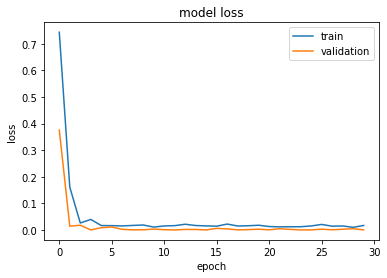

In [157]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [158]:
pred = model_lstm.predict(test_data_gen)

In [159]:
score, acc = model_lstm.evaluate(test_data_gen) #test

1/1 [==============================] - 0s 62ms/step - loss: 0.0219 - mse: 0.0219


In [160]:
test_data_gen[0]

(array([[[8.74508977e-01, 8.46216023e-01, 8.54779005e-01, 2.90011000e+05,
          8.53320003e-01, 1.48283467e-01],
         [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
          1.01481199e+00, 1.31502325e-01],
         [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
          1.00295198e+00, 1.53586280e-01],
         [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
          8.43836010e-01, 1.28670540e-01],
         [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.65050000e+05,
          9.99426007e-01, 1.14973180e-01]],
 
        [[1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
          1.01481199e+00, 1.31502325e-01],
         [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
          1.00295198e+00, 1.53586280e-01],
         [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
          8.43836010e-01, 1.28670540e-01],
         [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.6

In [161]:
pred

array([[0.9956407],
       [0.9956407],
       [0.9956407]], dtype=float32)

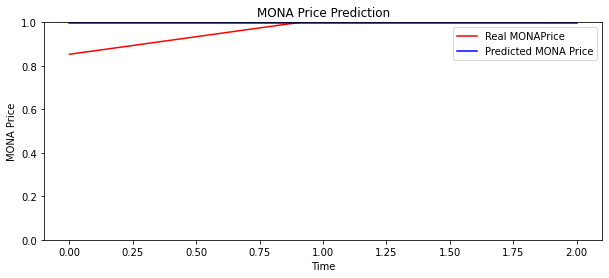

In [162]:
# Visualising the results
plt.figure(figsize=(10,4))
plt.plot(y_test[0:y_test.shape[0]-5], color = 'red', label = 'Real MONAPrice')
plt.plot(pred, color = 'blue', label = 'Predicted MONA Price')
plt.title('MONA Price Prediction')
plt.xlabel('Time')
plt.ylabel('MONA Price')
plt.ylim(0,1)
plt.legend()
plt.show()

In [163]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 15316), started 1:06:54 ago. (Use '!kill 15316' to kill it.)